# Face Recognition

Welcome! In this assignment, you're going to build a face recognition system. Many of the ideas presented here are from [FaceNet](https://arxiv.org/pdf/1503.03832.pdf). In the lecture, you also encountered [DeepFace](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf).

Face recognition problems commonly fall into one of two categories: 

**Face Verification** "Is this the claimed person?" For example, at some airports, you can pass through customs by letting a system scan your passport and then verifying that you (the person carrying the passport) are the correct person. A mobile phone that unlocks using your face is also using face verification. This is a 1:1 matching problem.

**Face Recognition** "Who is this person?" For example, the video lecture showed a [face recognition video](https://www.youtube.com/watch?v=wr4rx0Spihs) of Baidu employees entering the office without needing to otherwise identify themselves. This is a 1:K matching problem.

FaceNet learns a neural network that encodes a face image into a vector of 128 numbers. By comparing two such vectors, you can then determine if two pictures are of the same person.

By the end of this assignment, you'll be able to: 

* Differentiate between face recognition and face verification
* Implement one-shot learning to solve a face recognition problem
* Apply the triplet loss function to learn a network's parameters in the context of face recognition
* Explain how to pose face recognition as a binary classification problem
* Map face images into 128-dimensional encodings using a pretrained model
* Perform face verification and face recognition with these encodings



<a name='1'></a>
## 1 - Packages

Go ahead and run the cell below to import the packages you'll need.

In [ ]:
### v1.1

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
K.set_image_data_format('channels_last')
import os
import numpy as np
from numpy import genfromtxt
import pandas as pd
import tensorflow as tf
import PIL

%matplotlib inline
%load_ext autoreload
%autoreload 2

<a name='2'></a>
## 2 - Naive Face Verification

In Face Verification, you're given two images and you have to determine if they are of the same person. The simplest way to do this is to compare the two images pixel-by-pixel. If the distance between the raw images is below a chosen threshold, it may be the same person!

<img src="images/pixel_comparison.png" style="width:380px;height:150px;">
<caption><center> <u> <font color='purple'> <b>Figure 1</b> </u></center></caption>

Of course, this algorithm performs poorly, since the pixel values change dramatically due to variations in lighting, orientation of the person's face, minor changes in head position, and so on.

You'll see that rather than using the raw image, you can learn an encoding, $f(img)$.

By using an encoding for each image, an element-wise comparison produces a more accurate judgement as to whether two pictures are of the same person.

In [2]:
from tensorflow.keras.models import model_from_json

json_file = open('keras-facenet-h5/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('keras-facenet-h5/model.h5')

Now summarize the input and output shapes: 

In [3]:
print(model.inputs)
print(model.outputs)

[<tf.Tensor 'input_1:0' shape=(None, 160, 160, 3) dtype=float32>]
[<tf.Tensor 'Bottleneck_BatchNorm/batchnorm/add_1:0' shape=(None, 128) dtype=float32>]


In [4]:

def triplet_loss(y_true, y_pred, alpha = 0.2):
    
    
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
 
   
    
    pos_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,positive)),axis=-1)
   
    neg_dist = tf.reduce_sum(tf.square(tf.subtract(anchor,negative)),axis=-1)
    
    basic_loss = tf.maximum(tf.add(tf.subtract(pos_dist,neg_dist),alpha),0)
  
    loss = tf.reduce_sum(basic_loss)
    
    
    return loss

In [5]:
### YOU CANNOT EDIT THIS CELL

# BEGIN UNIT TEST
tf.random.set_seed(1)
y_true = (None, None, None) # It is not used
y_pred = (tf.keras.backend.random_normal([3, 128], mean=6, stddev=0.1, seed = 1),
          tf.keras.backend.random_normal([3, 128], mean=1, stddev=1, seed = 1),
          tf.keras.backend.random_normal([3, 128], mean=3, stddev=4, seed = 1))
loss = triplet_loss(y_true, y_pred)

assert type(loss) == tf.python.framework.ops.EagerTensor, "Use tensorflow functions"
print("loss = " + str(loss))

y_pred_perfect = ([[1., 1.]], [[1., 1.]], [[1., 1.,]])
loss = triplet_loss(y_true, y_pred_perfect, 5)
assert loss == 5, "Wrong value. Did you add the alpha to basic_loss?"
y_pred_perfect = ([[1., 1.]],[[1., 1.]], [[0., 0.,]])
loss = triplet_loss(y_true, y_pred_perfect, 3)
assert loss == 1., "Wrong value. Check that pos_dist = 0 and neg_dist = 2 in this example"
y_pred_perfect = ([[1., 1.]],[[0., 0.]], [[1., 1.,]])
loss = triplet_loss(y_true, y_pred_perfect, 0)
assert loss == 2., "Wrong value. Check that pos_dist = 2 and neg_dist = 0 in this example"
y_pred_perfect = ([[0., 0.]],[[0., 0.]], [[0., 0.,]])
loss = triplet_loss(y_true, y_pred_perfect, -2)
assert loss == 0, "Wrong value. Are you taking the maximum between basic_loss and 0?"
y_pred_perfect = ([[1., 0.], [1., 0.]],[[1., 0.], [1., 0.]], [[0., 1.], [0., 1.]])
loss = triplet_loss(y_true, y_pred_perfect, 3)
assert loss == 2., "Wrong value. Are you applying tf.reduce_sum to get the loss?"
y_pred_perfect = ([[1., 1.], [2., 0.]], [[0., 3.], [1., 1.]], [[1., 0.], [0., 1.,]])
loss = triplet_loss(y_true, y_pred_perfect, 1)
if (loss == 4.):
    raise Exception('Perhaps you are not using axis=-1 in reduce_sum?')
assert loss == 5, "Wrong value. Check your implementation"

# END UNIT TEST

loss = tf.Tensor(527.2598, shape=(), dtype=float32)


**Expected Output**:

<table>
    <tr>
        <td>
            <b>loss:</b>
        </td>
        <td>
           tf.Tensor(527.2598, shape=(), dtype=float32)
        </td>
    </tr>
    </table>

<a name='4'></a>
## 4 - Loading the Pre-trained Model

FaceNet is trained by minimizing the triplet loss. But since training requires a lot of data and a lot of computation, you won't train it from scratch here. Instead, you'll load a previously trained model in the following cell; which might take a couple of minutes to run.

In [6]:
FRmodel = model

Here are some examples of distances between the encodings between three individuals:

<img src="images/distance_matrix.png" style="width:380px;height:200px;"><br>
<caption><center> <u> <font color='purple'> <b>Figure 4:</b></u> <br>  <font color='purple'> Example of distance outputs between three individuals' encodings</center></caption>

Now use this model to perform face verification and face recognition!

<a name='5'></a>
## 5 - Applying the Model

You're building a system for an office building where the building manager would like to offer facial recognition to allow the employees to enter the building.

You'd like to build a face verification system that gives access to a list of people. To be admitted, each person has to swipe an identification card at the entrance. The face recognition system then verifies that they are who they claim to be.

<a name='5-1'></a>
### 5.1 - Face Verification

Now you'll build a database containing one encoding vector for each person who is allowed to enter the office. To generate the encoding, you'll use `img_to_encoding(image_path, model)`, which runs the forward propagation of the model on the specified image.

Run the following code to build the database (represented as a Python dictionary). This database maps each person's name to a 128-dimensional encoding of their face.

In [7]:
#tf.keras.backend.set_image_data_format('channels_last')
def img_to_encoding(image_path, model):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    img = np.around(np.array(img) / 255.0, decimals=12)
    x_train = np.expand_dims(img, axis=0)
    embedding = model.predict_on_batch(x_train)
    return embedding / np.linalg.norm(embedding, ord=2)

In [8]:
database = {}
database["danielle"] = img_to_encoding("images/danielle.png", FRmodel)
database["younes"] = img_to_encoding("images/younes.jpg", FRmodel)
database["tian"] = img_to_encoding("images/tian.jpg", FRmodel)
database["andrew"] = img_to_encoding("images/andrew.jpg", FRmodel)
database["kian"] = img_to_encoding("images/kian.jpg", FRmodel)
database["dan"] = img_to_encoding("images/dan.jpg", FRmodel)
database["sebastiano"] = img_to_encoding("images/sebastiano.jpg", FRmodel)
database["bertrand"] = img_to_encoding("images/bertrand.jpg", FRmodel)
database["kevin"] = img_to_encoding("images/kevin.jpg", FRmodel)
database["felix"] = img_to_encoding("images/felix.jpg", FRmodel)
database["benoit"] = img_to_encoding("images/benoit.jpg", FRmodel)
database["arnaud"] = img_to_encoding("images/arnaud.jpg", FRmodel)

Load the images of Danielle and Kian: 

In [25]:
danielle = tf.keras.preprocessing.image.load_img("images/danielle.png", target_size=(160, 160))
sebastiano = tf.keras.preprocessing.image.load_img("images/sebastiano.jpg", target_size=(160, 160))

In [26]:
np.around(np.array(sebastiano) / 255.0, decimals=12).shape

(160, 160, 3)

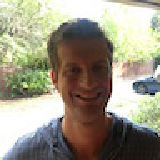

In [27]:
sebastiano

In [28]:
np.around(np.array(danielle) / 255.0, decimals=12).shape

(160, 160, 3)

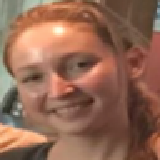

In [29]:
danielle

In [30]:


def verify(image_path, identity, database, model):
    
    encoding = img_to_encoding(image_path,model)
    
    dist = np.linalg.norm(encoding - database[identity])

    if dist < 0.7:
        print("It's " + str(identity) + ", welcome in!")
        door_open = True
    else:
        print("It's not " + str(identity) + ", please go away")
        door_open = False
         
    return dist, door_open

In [31]:
### YOU CANNOT EDIT THIS CELL

# BEGIN UNIT TEST
distance, door_open_flag = verify("images/camera_0.jpg", "younes", database, FRmodel)
assert np.isclose(distance, 0.5992949), "Distance not as expected"
assert isinstance(door_open_flag, bool), "Door open flag should be a boolean"
print("(", distance, ",", door_open_flag, ")")
# END UNIT TEST

It's younes, welcome in!
( 0.5992949 , True )


**Expected Output**:

<table>
    <tr>
        <td>
            <b>It's younes, welcome in!</b>
        </td>
        <td>
           (0.5992949, True)
        </td>
    </tr>
    </table>

Benoit, who does not work in the office, stole Kian's ID card and tried to enter the office. Naughty Benoit! The camera took a picture of Benoit ("images/camera_2.jpg). 

<img src="images/camera_2.jpg" style="width:100px;height:100px;">

Run the verification algorithm to check if Benoit can enter.

In [32]:
### YOU CANNOT EDIT THIS CELL

verify("images/camera_2.jpg", "kian", database, FRmodel)

It's not kian, please go away


(1.0259346, False)

**Expected Output**:

<table>
    <tr>
        <td>
            <b>It's not kian, please go away</b>
        </td>
        <td>
           (1.0259346, False)
        </td>
    </tr>
    </table>

In [33]:


def who_is_it(image_path, database, model):
 

    encoding = img_to_encoding(image_path,model)
    

    min_dist = 100
 
    for (name, db_enc) in database.items():
        
      
        dist = np.linalg.norm(encoding - db_enc)


        if dist < min_dist:
            min_dist = dist
            identity = name
   
    
    if min_dist > 0.7:
        print("Not in the database.")
    else:
        print ("it's " + str(identity) + ", the distance is " + str(min_dist))
        
    return min_dist, identity


Younes is at the front door and the camera takes a picture of him ("images/camera_0.jpg"). Let's see if your `who_it_is()` algorithm identifies Younes.

In [34]:
### YOU CANNOT EDIT THIS CELL

# BEGIN UNIT TEST
# Test 1 with Younes pictures 
who_is_it("images/camera_0.jpg", database, FRmodel)

# Test 2 with Younes pictures 
test1 = who_is_it("images/camera_0.jpg", database, FRmodel)
assert np.isclose(test1[0], 0.5992946)
assert test1[1] == 'younes'

# Test 3 with Younes pictures 
test2 = who_is_it("images/younes.jpg", database, FRmodel)
assert np.isclose(test2[0], 0.0)
assert test2[1] == 'younes'
# END UNIT TEST

it's younes, the distance is 0.5992949
it's younes, the distance is 0.5992949
it's younes, the distance is 0.0


**Expected Output**:

<table>
    <tr>
        <td>
            <b>it's younes, the distance is</b> 0.5992949<br>
            <b>it's younes, the distance is</b> 0.5992949<br>
            <b>it's younes, the distance is</b> 0.0<br>
        </td>
    </tr>
    </table>

You can change "camera_0.jpg" (picture of Younes) to "camera_1.jpg" (picture of Bertrand) and see the result.

<a name='6'></a>
 References
1. Florian Schroff, Dmitry Kalenichenko, James Philbin (2015). [FaceNet: A Unified Embedding for Face Recognition and Clustering](https://arxiv.org/pdf/1503.03832.pdf)

2. Yaniv Taigman, Ming Yang, Marc'Aurelio Ranzato, Lior Wolf (2014). [DeepFace: Closing the gap to human-level performance in face verification](https://research.fb.com/wp-content/uploads/2016/11/deepface-closing-the-gap-to-human-level-performance-in-face-verification.pdf)

3. This implementation also took a lot of inspiration from the official FaceNet github repository: https://github.com/davidsandberg/facenet

4. Further inspiration was found here: https://machinelearningmastery.com/how-to-develop-a-face-recognition-system-using-facenet-in-keras-and-an-svm-classifier/

5. And here: https://github.com/nyoki-mtl/keras-facenet/blob/master/notebook/tf_to_keras.ipynb